In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

In [5]:
BASE_PATH = str(Path.cwd().resolve().parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)
print(f"BASE_PATH: {BASE_PATH}")

BASE_PATH: /home/work


In [6]:
CURRENT_FILE_PATH = os.getcwd()  # Use os.getcwd() in Jupyter
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

In [7]:
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [8]:
from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

In [9]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
    """
    Load and preprocess BTC/KRW data for training, validation, and testing.
    
    Args:
        sequence_size (int): Number of time steps in each input sequence.
        validation_size (int): Number of samples in the validation set.
        test_size (int): Number of samples in the test set.
        is_regression (bool): If True, prepare data for regression tasks; if False, prepare for classification.

    Returns:
        tuple: DataLoaders for training, validation, and testing.
    """

    # Load cryptocurrency data and split into train, validation, and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
        get_cryptocurrency_data(
            sequence_size=sequence_size,  # Time steps per sequence
            validation_size=validation_size,  # Validation set size
            test_size=test_size,  # Test set size
            target_column='Close',  # Target column for prediction
            y_normalizer=1.0e7,  # Normalize target values (scale down by this factor)
            is_regression=is_regression  # Determine task type: regression or classification
        )

    # Print shapes for debugging (optional, uncomment if needed)
    # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

    # Shape explanation (debugging comment retained for reference):
    # - X_train.shape: [num_train_samples, sequence_size, num_features]
    # - y_train.shape: [num_train_samples]

    # Create datasets from the data
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # Create DataLoaders for batching and shuffling
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=wandb.config.batch_size,  # Use batch size from wandb config
        shuffle=True  # Shuffle data for training
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset,
        batch_size=wandb.config.batch_size,  # Validation set batch size
        shuffle=True  # Shuffle for validation
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset,
        batch_size=len(test_crypto_currency_dataset),  # Use full batch for testing
        shuffle=True  # Shuffle for test data
    )

    # Return DataLoaders for training, validation, and testing
    return train_data_loader, validation_data_loader, test_data_loader


In [10]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model

In [11]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

In [13]:
if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb
  # python g_crypto_currency_regression_train_lstm.py --wandb

usage: ipykernel_launcher.py [-h] [--wandb | --no-wandb] [-b BATCH_SIZE]
                             [-e EPOCHS] [-r LEARNING_RATE] [-w WEIGHT_DECAY]
                             [-v VALIDATION_INTERVALS]
                             [-p EARLY_STOP_PATIENCE] [-d EARLY_STOP_DELTA]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/work/.local/share/jupyter/runtime/kernel-711e647d-345c-45d3-99e1-a4b2acd3a08c.json


SystemExit: 2

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
import os
os.environ["PATH"] += r";C:\Users\didsu\AppData\Local\Programs\MiKTeX\miktex\bin\x64"

In [20]:
pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 171.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 298.1 MB/s eta 0:00:00
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import wandb
print(wandb.__version__)

0.19.1


In [6]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
import torch
print(torch.__version__)


2.3.0a0+40ec155e58.nv24.03


# 문제 1

### 문제 1-1 regression_train_lstm

In [9]:
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import sys

# 현재 작업 디렉토리 경로 설정
BASE_PATH = str(Path(os.getcwd()).resolve())
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = Path(os.getcwd()).resolve()
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"

# 체크포인트 디렉토리가 없으면 생성
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# 사용자 정의 모듈 가져오기 (환경에 따라 경로 확인 필요)
from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset


def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
    """
    BTC/KRW 데이터셋 로드 및 DataLoader 준비 함수.

    Args:
        sequence_size (int): 입력 시퀀스 크기.
        validation_size (int): 검증 데이터 크기.
        test_size (int): 테스트 데이터 크기.
        is_regression (bool): 회귀 여부.

    Returns:
        train_data_loader (DataLoader): 학습 데이터 로더.
        validation_data_loader (DataLoader): 검증 데이터 로더.
        test_data_loader (DataLoader): 테스트 데이터 로더.
    """
    # 데이터셋 생성
    X_train, X_validation, X_test, y_train, y_validation, y_test, _, _, _ = get_cryptocurrency_data(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=is_regression
    )

    # DataLoader로 래핑
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader


def get_model():
    """
    LSTM 기반 회귀 모델 생성 함수.

    Returns:
        model (nn.Module): LSTM 모델 인스턴스.
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            # LSTM을 통해 시퀀스 데이터 처리
            x, _ = self.lstm(x)
            # 마지막 타임스텝 출력 사용
            x = x[:, -1, :]  # x.shape: [batch_size, hidden_size]
            # FCN을 통해 결과 생성
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=1)


def main(config):
    """
    메인 학습 루프 함수.

    Args:
        config (dict): 학습 설정값 딕셔너리.
    """
    # 실행 시간 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 초기화
    wandb.init(
        mode="online" if config["wandb"] else "disabled",  # WandB 사용 여부
        project=config["project_name"],  # 프로젝트 이름
        notes="btc_krw experiment with lstm",  # WandB 설명
        tags=["lstm", "regression", "btc_krw"],  # 태그 추가
        name=run_time_str,  # 실행 이름
        config=config  # 설정 로깅
    )

    # 데이터 로드
    train_data_loader, validation_data_loader, _ = get_btc_krw_data()

    # 디바이스 설정 (GPU가 사용 가능하면 GPU 사용)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성 및 디바이스 이동
    model = get_model()
    model.to(device)

    # 옵티마이저 설정
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # RegressionTrainer 초기화
    regression_trainer = RegressionTrainer(
        config["project_name"], model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )

    # 학습 루프 실행
    regression_trainer.train_loop()

    # WandB 종료
    wandb.finish()


# 학습 설정값
config = {
    "epochs": 10,  # 학습 에포크 수
    "batch_size": 32,  # 배치 크기
    "validation_intervals": 2,  # 검증 주기
    "learning_rate": 0.001,  # 학습률
    "early_stop_patience": 5,  # 얼리 스톱 기준
    "early_stop_delta": 0.001,  # 얼리 스톱 기준 변화량
    "weight_decay": 0.0001,  # 가중치 감쇠
    "wandb": True,  # WandB 사용 여부
    "project_name": "lstm_regression_btc_krw"  # 프로젝트 이름
}

# 메인 실행
main(config)


Training on device cuda:0.
[Epoch   1] T_loss: 1.16096, V_loss: 1.22297, Early stopping is stated! | T_time: 00:00:01, T_speed: 0.007
[Epoch   2] T_loss: 0.04129, V_loss: 1.19979, V_loss decreased (1.22297 --> 1.19979). Saving model... | T_time: 00:00:01, T_speed: 0.002
[Epoch   4] T_loss: 0.03043, V_loss: 0.76583, V_loss decreased (1.19979 --> 0.76583). Saving model... | T_time: 00:00:03, T_speed: 0.006
[Epoch   6] T_loss: 0.02653, V_loss: 1.06239, Early stopping counter: 1 out of 5 | T_time: 00:00:05, T_speed: 0.040
[Epoch   8] T_loss: 0.02258, V_loss: 0.53004, V_loss decreased (0.76583 --> 0.53004). Saving model... | T_time: 00:00:06, T_speed: 0.013
[Epoch  10] T_loss: 0.01967, V_loss: 0.43532, V_loss decreased (0.53004 --> 0.43532). Saving model... | T_time: 00:00:08, T_speed: 0.030
Final training time: 00:00:08


Epoch,▁▂▃▅▆█
Training loss,█▁▁▁▁▁
Training speed (epochs/sec.),▂▁▂█▃▆
Validation loss,██▄▇▂▁
Epoch,10
Training loss,0.01967
Training speed (epochs/sec.),0.0303
Validation loss,0.43532


### 문제 1-2 regression_test_lstm

MODEL FILE: /home/work/HW4/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,078.40 <--> 1,373.29 (Loss:        294.89)
 1: 1,073.27 <--> 1,390.43 (Loss:        317.16)
 2: 1,070.69 <--> 1,319.45 (Loss:        248.76)
 3: 1,085.14 <--> 1,302.60 (Loss:        217.47)
 4: 1,075.72 <--> 1,331.62 (Loss:        255.90)
 5: 1,081.54 <--> 1,284.38 (Loss:        202.85)
 6: 1,072.64 <--> 1,380.87 (Loss:        308.23)
 7: 1,079.10 <--> 1,360.09 (Loss:        281.00)
 8: 1,083.51 <--> 1,378.05 (Loss:        294.54)
 9: 1,075.29 <--> 1,334.58 (Loss:        259.29)


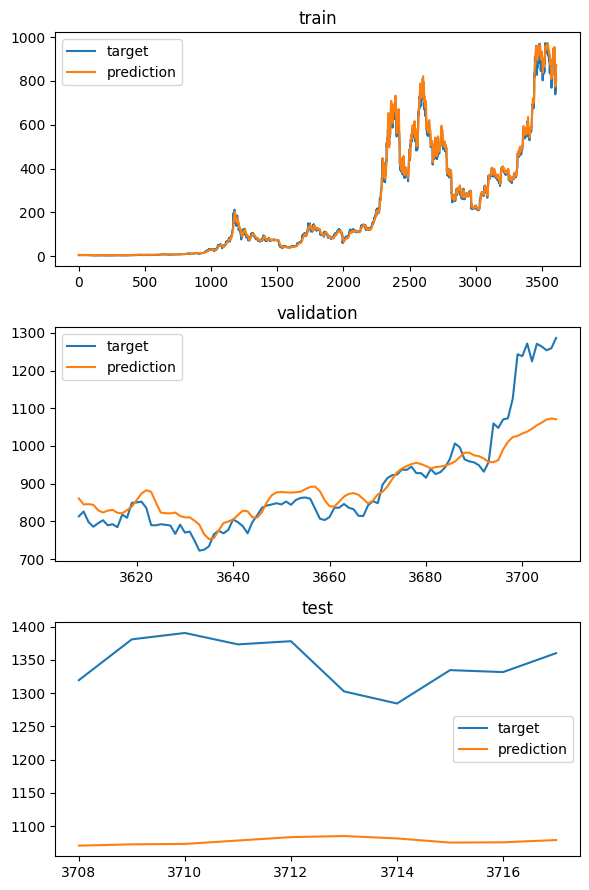

In [10]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

# 현재 디렉토리와 체크포인트 경로 설정
CURRENT_FILE_PATH = Path.cwd()
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"
if not CHECKPOINT_FILE_PATH.exists():
    os.makedirs(CHECKPOINT_FILE_PATH)  # 체크포인트 디렉토리 생성

# 사용자 정의 데이터 및 모델 모듈 임포트
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset
from g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
    """
    테스트 데이터셋에 대해 모델을 평가합니다.

    Args:
        test_model (torch.nn.Module): 학습된 모델.
    """
    # 테스트 데이터 로더 가져오기
    _, _, test_data_loader = get_btc_krw_data()

    # 모델 평가 모드 설정
    test_model.eval()

    y_normalizer = 100  # 값 복원 스케일링을 위한 상수

    print("[TEST DATA]")
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            # 모델 예측 수행
            output_test = test_model(input_test)

        # 각 샘플별 예측 결과와 실제 값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,  # 예측 값
                target.item() * y_normalizer,  # 실제 값
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer  # 손실
            ))


def predict_all(test_model):
    """
    학습, 검증, 테스트 데이터셋에 대해 예측값을 생성하고 시각화합니다.

    Args:
        test_model (torch.nn.Module): 학습된 모델.
    """
    y_normalizer = 100  # 값 복원 스케일링을 위한 상수

    # 데이터셋 가져오기
    X_train, X_validation, X_test, y_train, y_validation, y_test, _, _, _ = \
        get_cryptocurrency_data(
            sequence_size=10, validation_size=100, test_size=10,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
        )

    # 데이터셋 생성
    dataset_list = [
        CryptoCurrencyDataset(X_train, y_train),
        CryptoCurrencyDataset(X_validation, y_validation),
        CryptoCurrencyDataset(X_test, y_test)
    ]
    dataset_labels = ["train", "validation", "test"]
    num = 0
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    # 각 데이터셋별 예측값과 실제값 시각화
    for i, dataset in enumerate(dataset_list):
        X, TARGET_Y, PREDICTION_Y = [], [], []
        for data in dataset:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)  # 실제값 복원
            PREDICTION_Y.append(prediction.item() * y_normalizer)  # 예측값 복원

            num += 1

        axs[i].plot(X, TARGET_Y, label='target')  # 실제 값
        axs[i].plot(X, PREDICTION_Y, label='prediction')  # 예측 값
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()  # 그래프 출력


def main():
    """
    모델 로드 후 테스트 및 시각화 루프를 실행합니다.
    """
    # 테스트 설정값
    config = {
        'epochs': 10,
        'batch_size': 32,
        'validation_intervals': 2,
        'learning_rate': 0.001,
        'early_stop_patience': 3,
        'early_stop_delta': 0.01,
    }

    # WandB 초기화 (테스트 모드로 실행)
    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        config=config
    )

    # 학습된 모델 생성
    test_model = get_model()

    # 저장된 체크포인트 로드
    latest_file_path = CHECKPOINT_FILE_PATH / f"{project_name}_checkpoint_latest.pt"
    print(f"MODEL FILE: {latest_file_path}")

    # 모델 상태 로드
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 테스트 및 결과 시각화
    test(test_model)
    predict_all(test_model)


# main 함수 직접 호출 (Jupyter 환경에 맞게 수정)
main()


### 문제 1-3 classification_train_lstm

In [12]:
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import torch
import sys

# 현재 실행 중인 Jupyter Notebook 환경에서 작업 디렉토리를 기준으로 경로를 설정
CURRENT_DIR = Path(os.getcwd()).resolve()
BASE_PATH = CURRENT_DIR  # 스크립트가 원하는 디렉토리 내에서 실행된다고 가정
sys.path.append(str(BASE_PATH))  # 필요한 모듈 탐색 경로에 BASE_PATH 추가

# 체크포인트 저장 경로 설정 (없다면 생성)
CHECKPOINT_FILE_PATH = CURRENT_DIR / "checkpoints"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# 필요한 모듈 임포트
# c_trainer.py, f_arg_parser.py, g_crypto_currency_regression_train_lstm.py는
# 같은 디렉토리(또는 설정한 BASE_PATH) 내에 존재한다고 가정
from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data


def get_model():
    """
    LSTM 기반 분류 모델을 정의하는 함수.
    - 입력 차원: n_input
    - 출력 차원: n_output
    - LSTM 계층: 입력 크기 5, 은닉 크기 256, 레이어 수 3개
    - 최종적으로 FCN(완전연결층)을 통해 2개 클래스에 대한 로짓 반환
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            # LSTM: 입력 특성 수 = n_input, 은닉 상태 크기 = 256, LSTM 레이어 수 = 3
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
            # FCN: LSTM의 마지막 은닉 상태 출력(256차원)을 n_output 차원으로 매핑
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            # x: (배치 크기, 시퀀스 길이, 특성 수)
            x, hidden = self.lstm(x)
            # LSTM 출력 중 마지막 타임스텝의 은닉 상태만 사용
            x = x[:, -1, :]  
            # 최종 fully connected layer
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=2)


def main(config):
    """
    LSTM 분류 모델 학습 메인 루프 함수.
    1. W&B(Weights & Biases) 설정
    2. 데이터 로더 준비
    3. 디바이스 선택(CPU/GPU)
    4. 모델 구성 및 옵티마이저 설정
    5. ClassificationTrainer를 통해 학습 진행
    6. WandB 종료
    """
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # W&B 초기화: wandb=True일 경우 online 모드, 아니면 disabled
    wandb.init(
        mode="online" if config["wandb"] else "disabled",
        project=config["project_name"],
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 회귀가 아닌 분류 모드로 BTC/KRW 데이터 로드
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)

    # GPU 사용 가능 시 GPU 사용, 아니면 CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 준비 및 디바이스 할당
    model = get_model()
    model.to(device)

    # 옵티마이저(Adam) 설정 - 러닝레이트와 weight_decay는 config에 따라 다름
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # ClassificationTrainer 초기화
    # train_loop() 내에서 실제로 학습, 검증, 체크포인트 저장 등을 수행
    classification_trainer = ClassificationTrainer(
        config["project_name"], model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    # W&B 사용 종료
    wandb.finish()


# Jupyter Notebook 상에서 argparse를 흉내낸 config 딕셔너리
config = {
    "epochs": 100,
    "batch_size": 32,
    "validation_intervals": 2,
    "learning_rate": 0.00001,
    "early_stop_patience": 10,
    "early_stop_delta": 0.001,
    "weight_decay": 0.0001,
    "wandb": True,  # WandB 사용 여부(True면 online, False면 disabled)
    "project_name": "lstm_classification_btc_krw"
}

# 메인 함수 실행 (학습 시작)
main(config)

# WandB URL #2 : https://wandb.ai/-ddj127-korea-university-of-technology-and-education/lstm_classification_btc_krw/runs/kx6m5yfl


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69232, T_accuracy: 52.7993 | V_loss: 0.69174, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69189, T_accuracy: 52.7993 | V_loss: 0.68953, V_accuracy: 56.0000 | V_loss decreased (0.69174 --> 0.68953). Saving model... | T_time: 00:00:01, T_speed: 2.000
[Epoch   4] T_loss: 0.69129, T_accuracy: 52.7993 | V_loss: 0.69262, V_accuracy: 55.0000 | Early stopping counter: 1 out of 10 | T_time: 00:00:02, T_speed: 2.000
[Epoch   6] T_loss: 0.69106, T_accuracy: 52.8825 | V_loss: 0.69228, V_accuracy: 57.0000 | Early stopping counter: 2 out of 10 | T_time: 00:00:03, T_speed: 2.000
[Epoch   8] T_loss: 0.69090, T_accuracy: 52.9933 | V_loss: 0.69335, V_accuracy: 49.0000 | Early stopping counter: 3 out of 10 | T_time: 00:00:04, T_speed: 2.000
[Epoch  10] T_loss: 0.69084, T_accuracy: 53.0211 | V_loss: 0.69415, V_accuracy: 44.0000 | Early stopping counter: 4 out of 10 | T_time: 00:00:06, T_speed: 1.6

Epoch,▁▁▂▃▃▄▅▅▆▇▇█
Training accuracy (%),▁▁▁▃▅▅▆█▆▇▅▄
Training loss,█▆▄▂▂▂▂▁▁▁▁▁
Training speed (epochs/sec.),▁████▇▇▇▇▇▆▆
Validation accuracy (%),▇▇▇█▄▁▁▁▁▁▁▁
Validation loss,▂▁▃▃▃▄▇▃▇▇▆█
Epoch,22
Training accuracy (%),52.96563
Training loss,0.69077
Training speed (epochs/sec.),1.57143
Validation accuracy (%),44


### 1-4 classification_test_lstm

In [14]:
import os
from pathlib import Path
from datetime import datetime
import torch
import wandb
import sys

# 현재 Jupyter Notebook 환경을 고려하여 작업 경로 설정
CURRENT_FILE_PATH = Path(os.getcwd()).resolve()
BASE_PATH = CURRENT_FILE_PATH

# 체크포인트를 저장할 디렉토리 생성(이미 존재하면 예외 없이 넘어감)
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# BASE_PATH를 sys.path에 추가하여 모듈 탐색 경로로 사용
sys.path.append(str(BASE_PATH))

# 필요한 모듈 임포트
# g_crypto_currency_regression_train_lstm 및 i_crypto_currency_classification_train_lstm
# 같은 디렉토리 또는 BASE_PATH 하위 디렉토리에 존재한다고 가정
from g_crypto_currency_regression_train_lstm import get_btc_krw_data
from i_crypto_currency_classification_train_lstm import get_model


def test(test_model):
    """
    테스트 데이터에 대해 모델의 성능을 평가하는 함수.
    분류 모델이므로 테스트 정확도를 계산하고, 일부 예측 결과를 출력한다.
    
    Args:
        test_model (nn.Module): 테스트할 분류 모델.
    """
    # is_regression=False로 데이터를 가져오면 분류 문제에 맞는 DataLoader를 얻는다.
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    # 모델을 평가 모드로 설정 (Dropout 등 비활성화)
    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0

    print("[TEST DATA]")
    # 그래디언트 계산 비활성화
    with torch.no_grad():
        for test_batch in test_data_loader:
            # test_batch는 (입력 텐서, 타겟 텐서)의 튜플 형태
            input_test, target_test = test_batch

            # 모델 추론
            output_test = test_model(input_test)

            # output_test는 클래스 로짓값. argmax를 통해 예측 클래스 도출
            predicted_test = torch.argmax(output_test, dim=1)

            # 정확도 계산을 위해 정답 여부 카운트
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))
            num_tested_samples += len(input_test)

        # 정확도(%) 계산
        test_accuracy = 100.0 * num_corrects_test / num_tested_samples
        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        # 일부 예측 결과 출력 (출력 포맷: 인덱스: 예측값 <--> 실제값)
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))


def main(config):
    """
    메인 테스트 함수:
    1. WandB 비활성화 설정으로 초기화(로그 남기지 않음)
    2. 모델 체크포인트 로드
    3. test() 함수로 테스트 데이터에 대해 성능 평가
    
    Args:
        config (dict): 학습 및 테스트 관련 설정 정보 딕셔너리
    """
    # 현재 시간 문자열 (런 네이밍에 사용)
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 런 초기화 - 로그 비활성화 모드
    wandb.init(
        mode="disabled",
        project=config["project_name"],
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 분류 모델 로드 (모델 구조 획득)
    test_model = get_model()

    # 최신 체크포인트 파일 경로 설정
    latest_file_path = CHECKPOINT_FILE_PATH / f"{config['project_name']}_checkpoint_latest.pt"
    print(f"MODEL FILE: {latest_file_path}")

    # CPU 환경에서 모델 파라미터 로드
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 테스트 함수 호출
    test(test_model)


# argparse를 사용하지 않는 대신 Jupyter에서 config 딕셔너리로 설정값을 전달
config = {
    "epochs": 100,
    "batch_size": 32,
    "validation_intervals": 2,
    "learning_rate": 0.00001,
    "early_stop_patience": 10,
    "early_stop_delta": 0.001,
    "project_name": "lstm_classification_btc_krw"
}

# main 함수 호출로 테스트 실행
main(config)


MODEL FILE: /home/work/HW4/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 60.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00


# 문제 2

### 문제 2-1
classification_train_lstm의 적절한 새로운 모델 구성 및 하이퍼 파라미터 찾기


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69392, T_accuracy: 47.9728 | V_loss: 0.69351, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69261, T_accuracy: 52.3391 | V_loss: 0.69292, V_accuracy: 52.6667 | Early stopping counter: 1 out of 10 | T_time: 00:00:01, T_speed: 2.000
[Epoch   4] T_loss: 0.69194, T_accuracy: 52.8494 | V_loss: 0.69229, V_accuracy: 52.6667 | V_loss decreased (0.69351 --> 0.69229). Saving model... | T_time: 00:00:03, T_speed: 1.333
[Epoch   6] T_loss: 0.69145, T_accuracy: 53.0763 | V_loss: 0.69210, V_accuracy: 52.6667 | Early stopping counter: 1 out of 10 | T_time: 00:00:04, T_speed: 1.500
[Epoch   8] T_loss: 0.69158, T_accuracy: 52.9629 | V_loss: 0.69252, V_accuracy: 52.6667 | Early stopping counter: 2 out of 10 | T_time: 00:00:06, T_speed: 1.333
[Epoch  10] T_loss: 0.69104, T_accuracy: 53.0763 | V_loss: 0.69270, V_accuracy: 53.3333 | Early stopping counter: 3 out of 10 | T_time: 00:00:07, T_speed: 1.4

Epoch,▁▁▂▃▃▄▄▅▆▆▇▇█
Training accuracy (%),▁▇▇█▇█▇███▇▇█
Training loss,█▅▄▃▄▂▂▂▁▃▂▁▂
Training speed (epochs/sec.),▁█▆▆▆▆▆▆▆▆▆▆▆
Validation accuracy (%),▁▇▇▇▇█▅▁▁▁▁▁▁
Validation loss,▆▄▂▁▂▃▄▇▇▆▆█▆
Epoch,24
Training accuracy (%),53.4165
Training loss,0.69055
Training speed (epochs/sec.),1.33333
Validation accuracy (%),47.33333


###  문제 2-1 진행 -test 진행

In [17]:
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import torch
import sys

# 현재 Jupyter Notebook 환경을 고려하여 디렉토리 설정
CURRENT_DIR = Path(os.getcwd()).resolve()
BASE_PATH = CURRENT_DIR  # 현재 디렉토리를 BASE_PATH로 사용
sys.path.append(str(BASE_PATH))  # BASE_PATH를 sys.path에 추가해 모듈 탐색 가능

# 체크포인트를 저장할 디렉토리 생성 (존재하지 않으면 생성)
CHECKPOINT_FILE_PATH = CURRENT_DIR / "checkpoints"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# 외부 모듈 임포트
# c_trainer.py, f_arg_parser.py, g_crypto_currency_regression_train_lstm.py는
# 현재 디렉토리(또는 BASE_PATH)내에 있다고 가정
from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data


def get_model(hidden_size=256, lstm_layers=3, n_input=5, n_output=1):
    """
    회귀용 LSTM 모델을 정의하는 함수.
    현재 코드에서는 분류용 모델을 사용하려면 get_model() 내부를 수정하거나
    별도의 모델 정의 함수가 필요하다.

    Args:
        hidden_size (int): LSTM 은닉 상태 크기
        lstm_layers (int): LSTM 레이어 수
        n_input (int): 입력 특성의 수
        n_output (int): 출력 차원 수

    Returns:
        nn.Module: 정의된 LSTM 기반 모델 인스턴스
    """

    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, lstm_layers):
            super().__init__()
            # LSTM 레이어 정의
            # batch_first=True 로 배치 차원이 첫 번째 차원
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=lstm_layers,
                batch_first=True
            )
            # 최종 FC 레이어: LSTM의 마지막 타임스텝 출력을 n_output 차원으로 매핑
            self.fcn = nn.Linear(in_features=hidden_size, out_features=n_output)

        def forward(self, x):
            # x: (batch, seq_len, features)
            x, _ = self.lstm(x)
            # LSTM의 마지막 타임스텝 출력 사용: (batch, hidden_size)
            x = x[:, -1, :]
            # FC 레이어 통과
            x = self.fcn(x)
            return x

    return MyModel(n_input=n_input, n_output=n_output, hidden_size=hidden_size, lstm_layers=lstm_layers)


def main(config):
    """
    LSTM 분류 모델 학습 메인 함수.
    다양한 하이퍼파라미터로 실험을 진행할 수 있으며, WandB로 로그를 남길 수 있다.

    1. WandB 런 초기화
    2. 디바이스 설정(CPU 또는 GPU)
    3. 데이터 로드(분류용 데이터)
    4. 모델 초기화 (현재 회귀용 모델로 정의되어 있으나 config에 맞게 수정 필요)
    5. 옵티마이저 정의
    6. ClassificationTrainer를 사용해 학습 진행
    7. WandB 종료

    Args:
        config (dict): 학습 설정값 딕셔너리
    """
    # 현재 시간 문자열 (런 이름에 사용)
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 런 초기화
    wandb.init(
        mode="online" if config["wandb"] else "disabled",
        project=config["project_name"],
        # 러닝레이트, weight_decay, dropout_rate, LSTM 레이어 수를 이름에 반영해 실험 트래킹
        name=f"Run_{run_time_str}_LR{config['learning_rate']}_WD{config['weight_decay']}_Dropout{config['dropout_rate']}_LSTM{config['lstm_layers']}",
        tags=["lstm", "classification", f"dropout_{config['dropout_rate']}", f"lstm_layers_{config['lstm_layers']}"],
        notes="Experiment with various hyperparameters",
        config=config
    )

    # 디바이스 설정: GPU 사용 가능 시 GPU 사용, 아니면 CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 데이터 로드: 현재 함수는 회귀/분류를 모두 지원하므로 is_regression=False로 분류용 데이터로딩
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(
        sequence_size=30,
        validation_size=150,
        test_size=30,
        is_regression=False
    )

    # 모델 초기화
    # 주석 처리된 get_model과 현재 get_model의 정의가 달라서, 실제 분류 모델로 학습하려면 
    # 분류용 get_model()을 사용하거나 여기서 모델 정의를 수정해야 한다.
    # 아래는 회귀용 모델을 호출하나, config에 따라 파라미터를 넣어 분류용 모델로 재정의 필요.
    model = get_model(
        hidden_size=config["hidden_size"],
        lstm_layers=config["lstm_layers"],
        n_input=5,  # 입력 특성 수 (데이터셋에 맞게 수정)
        n_output=2  # 분류이므로 클래스 수 2를 가정 (실제 데이터셋에 맞게 조정)
    )
    model.to(device)

    # 옵티마이저(Adam) 초기화
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # ClassificationTrainer 인스턴스 생성
    # train_loop() 실행 시 학습/검증 루프와 체크포인트 저장, WandB 로깅 처리
    classification_trainer = ClassificationTrainer(
        config["project_name"], model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    # WandB 실험 종료
    wandb.finish()


# 학습 설정 딕셔너리
config = {
    "epochs": 100,
    "batch_size": 32,
    "validation_intervals": 2,
    "learning_rate": 0.0001,  # 초기 러닝레이트
    "early_stop_patience": 10,
    "early_stop_delta": 0.001,
    "weight_decay": 1e-6,     # 초기 weight decay
    "dropout_rate": 0.5,      # 초기 dropout_rate
    "lstm_layers": 4,         # 초기 LSTM 레이어 수
    "fc_layers": 3,           # 초기 FC 레이어 수 (현재 get_model에서는 사용되지 않음)
    "hidden_size": 512,       # 초기 은닉 상태 크기
    "wandb": True,
    "project_name": "lstm_classification_btc_krw"
}

# 실험 1: dropout_rate, weight_decay, lstm_layers, fc_layers 조정
config.update({"dropout_rate": 0.1, "weight_decay": 1e-5, "lstm_layers": 2, "fc_layers": 3})
main(config)

# 실험 2: 또 다른 파라미터 조합
config.update({"dropout_rate": 0.3, "weight_decay": 1e-6, "lstm_layers": 3, "fc_layers": 2})
main(config)

# 실험 3: 또 다른 파라미터 조합
config.update({"dropout_rate": 0.5, "weight_decay": 0, "lstm_layers": 4, "fc_layers": 1})
main(config)

# 마지막 main 호출
main(config)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69152, T_accuracy: 53.1552 | V_loss: 0.69131, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69104, T_accuracy: 52.6435 | V_loss: 0.69537, V_accuracy: 47.3333 | Early stopping counter: 1 out of 10 | T_time: 00:00:01, T_speed: 2.000
[Epoch   4] T_loss: 0.69129, T_accuracy: 52.9278 | V_loss: 0.69277, V_accuracy: 52.6667 | Early stopping counter: 2 out of 10 | T_time: 00:00:02, T_speed: 2.000
[Epoch   6] T_loss: 0.69109, T_accuracy: 53.2405 | V_loss: 0.69365, V_accuracy: 47.3333 | Early stopping counter: 3 out of 10 | T_time: 00:00:04, T_speed: 1.500
[Epoch   8] T_loss: 0.69108, T_accuracy: 52.7857 | V_loss: 0.69383, V_accuracy: 47.3333 | Early stopping counter: 4 out of 10 | T_time: 00:00:05, T_speed: 1.600
[Epoch  10] T_loss: 0.69106, T_accuracy: 53.1268 | V_loss: 0.69354, V_accuracy: 50.6667 | Early stopping counter: 5 out of 10 | T_time: 00:00:07, T_speed: 1.429
[Epoch  12] T_los

Epoch,▁▁▂▃▄▄▅▆▇▇█
Training accuracy (%),▅▁▃▆▂▅▅█▄█▅
Training loss,█▃▆▄▃▃▁▃▁▂▁
Training speed (epochs/sec.),▁██▆▇▆▆▆▆▆▆
Validation accuracy (%),█▁█▁▁▅▁▁▁▁▁
Validation loss,▁█▃▅▅▅▆▇▆█▆
Epoch,20
Training accuracy (%),53.1552
Training loss,0.69088
Training speed (epochs/sec.),1.42857
Validation accuracy (%),47.33333


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69193, T_accuracy: 51.7339 | V_loss: 0.69230, V_accuracy: 54.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69147, T_accuracy: 53.0699 | V_loss: 0.69206, V_accuracy: 52.6667 | Early stopping counter: 1 out of 10 | T_time: 00:00:01, T_speed: 2.000
[Epoch   4] T_loss: 0.69124, T_accuracy: 53.0131 | V_loss: 0.69153, V_accuracy: 52.6667 | Early stopping counter: 2 out of 10 | T_time: 00:00:03, T_speed: 1.333
[Epoch   6] T_loss: 0.69138, T_accuracy: 52.7572 | V_loss: 0.69216, V_accuracy: 52.6667 | Early stopping counter: 3 out of 10 | T_time: 00:00:05, T_speed: 1.200
[Epoch   8] T_loss: 0.69107, T_accuracy: 53.1552 | V_loss: 0.69365, V_accuracy: 47.3333 | Early stopping counter: 4 out of 10 | T_time: 00:00:07, T_speed: 1.143
[Epoch  10] T_loss: 0.69106, T_accuracy: 53.1552 | V_loss: 0.69283, V_accuracy: 52.0000 | Early stopping counter: 5 out of 10 | T_time: 00:00:09, T_speed: 1.111
[Epoch  12] T_los

Epoch,▁▁▂▃▄▄▅▆▇▇█
Training accuracy (%),▁▇▇▆██▅▆▇▇█
Training loss,█▅▃▄▂▂▁▁▂▁▁
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅
Validation accuracy (%),█▆▆▆▁▅▇▁▂▄▇
Validation loss,▃▃▁▃█▅▅█▇▇▆
Epoch,20
Training accuracy (%),53.18363
Training loss,0.69092
Training speed (epochs/sec.),1.05263
Validation accuracy (%),54


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69249, T_accuracy: 52.1035 | V_loss: 0.69212, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:01, T_speed: 1.000
[Epoch   2] T_loss: 0.69113, T_accuracy: 52.4730 | V_loss: 0.69248, V_accuracy: 52.6667 | Early stopping counter: 1 out of 10 | T_time: 00:00:02, T_speed: 1.000
[Epoch   4] T_loss: 0.69149, T_accuracy: 52.7004 | V_loss: 0.69226, V_accuracy: 52.6667 | Early stopping counter: 2 out of 10 | T_time: 00:00:04, T_speed: 1.000
[Epoch   6] T_loss: 0.69143, T_accuracy: 52.4161 | V_loss: 0.69258, V_accuracy: 52.6667 | Early stopping counter: 3 out of 10 | T_time: 00:00:07, T_speed: 0.857
[Epoch   8] T_loss: 0.69125, T_accuracy: 53.1268 | V_loss: 0.69307, V_accuracy: 50.6667 | Early stopping counter: 4 out of 10 | T_time: 00:00:09, T_speed: 0.889
[Epoch  10] T_loss: 0.69114, T_accuracy: 52.8425 | V_loss: 0.69277, V_accuracy: 56.0000 | Early stopping counter: 5 out of 10 | T_time: 00:00:11, T_speed: 0.909
[Epoch  12] T_los

Epoch,▁▁▂▃▄▄▅▆▇▇█
Training accuracy (%),▁▃▄▃▆▅█▆▄▆▆
Training loss,█▂▃▃▂▂▁▂▁▁▁
Training speed (epochs/sec.),███▁▃▄▁▂▃▁▂
Validation accuracy (%),▅▅▅▅▄█▅▇▃▁▁
Validation loss,▁▂▁▂▃▂▂▂▃█▅
Epoch,20
Training accuracy (%),52.98465
Training loss,0.69097
Training speed (epochs/sec.),0.86957
Validation accuracy (%),47.33333


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69242, T_accuracy: 52.2456 | V_loss: 0.69218, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:01, T_speed: 1.000
[Epoch   2] T_loss: 0.69170, T_accuracy: 52.7857 | V_loss: 0.69158, V_accuracy: 52.6667 | Early stopping counter: 1 out of 10 | T_time: 00:00:02, T_speed: 1.000
[Epoch   4] T_loss: 0.69187, T_accuracy: 52.6151 | V_loss: 0.69213, V_accuracy: 52.6667 | Early stopping counter: 2 out of 10 | T_time: 00:00:04, T_speed: 1.000
[Epoch   6] T_loss: 0.69126, T_accuracy: 52.8709 | V_loss: 0.69366, V_accuracy: 47.3333 | Early stopping counter: 3 out of 10 | T_time: 00:00:07, T_speed: 0.857
[Epoch   8] T_loss: 0.69122, T_accuracy: 52.7572 | V_loss: 0.69269, V_accuracy: 54.6667 | Early stopping counter: 4 out of 10 | T_time: 00:00:09, T_speed: 0.889
[Epoch  10] T_loss: 0.69135, T_accuracy: 52.8994 | V_loss: 0.69233, V_accuracy: 52.6667 | Early stopping counter: 5 out of 10 | T_time: 00:00:11, T_speed: 0.909
[Epoch  12] T_los

Epoch,▁▁▂▃▄▄▅▆▇▇█
Training accuracy (%),▁▄▃▅▄▅▄▆▆▄█
Training loss,█▅▅▃▂▃▂▁▃▁▂
Training speed (epochs/sec.),███▁▃▄▁▂▃▁▂
Validation accuracy (%),▆▆▆▂█▆▁▇▁█▇
Validation loss,▃▁▃█▅▄▇▅▆▅▅
Epoch,20
Training accuracy (%),53.43945
Training loss,0.69107
Training speed (epochs/sec.),0.86957
Validation accuracy (%),53.33333


### 2-1 regression training

In [25]:
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import torch
import sys

# 현재 Jupyter Notebook 환경에 맞추어 작업 디렉토리 및 경로 설정
CURRENT_DIR = Path(os.getcwd()).resolve()
BASE_PATH = CURRENT_DIR
sys.path.append(str(BASE_PATH))  # BASE_PATH를 sys.path에 추가하여 모듈 탐색 경로 확보

# 체크포인트를 저장할 디렉토리 설정 (존재하지 않으면 생성)
CHECKPOINT_FILE_PATH = CURRENT_DIR / "checkpoints"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# 필요한 외부 모듈 임포트
# (c_trainer.py, f_arg_parser.py, g_crypto_currency_regression_train_lstm.py는 BASE_PATH 내에 존재한다고 가정)
from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data


def get_model(hidden_size=256, lstm_layers=3, n_input=5, n_output=2):
    """
    LSTM 기반 분류 모델 정의 함수.
    입력: n_input (특성 수), n_output(출력 클래스 수), hidden_size(은닉층 크기), lstm_layers(LSTM 레이어 수)
    출력: 정의된 nn.Module 모델 인스턴스
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, lstm_layers):
            super().__init__()
            # LSTM 레이어 정의
            # batch_first=True로 batch 차원을 맨 앞으로
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=lstm_layers,
                batch_first=True
            )
            # 마지막 타임스텝의 hidden state를 받아 fully connected layer로 출력
            self.fcn = nn.Linear(in_features=hidden_size, out_features=n_output)

        def forward(self, x):
            # x 형태: (batch, sequence_length, n_input)
            x, _ = self.lstm(x)     # LSTM 통과
            x = x[:, -1, :]         # 마지막 타임스텝의 은닉상태만 사용
            x = self.fcn(x)         # FC layer 통해 클래스 로짓값 출력
            return x

    return MyModel(n_input=n_input, n_output=n_output, hidden_size=hidden_size, lstm_layers=lstm_layers)


def main(config):
    """
    LSTM 분류 모델 학습 메인 함수.
    1. WandB 초기화 (config에 따라 online/disabled 모드)
    2. GPU/CPU 디바이스 설정
    3. 데이터 로드 (classification 용도로 is_regression=False)
    4. 모델 초기화 및 파라미터 설정
    5. 옵티마이저(Adam) 설정
    6. ClassificationTrainer를 통한 학습 루프 실행
    7. 학습 종료 후 WandB finish

    Args:
        config (dict): 학습 관련 설정 값을 담은 딕셔너리
    """
    # 현재 시간 문자열 추출(런 이름에 사용)
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 런 초기화
    wandb.init(
        mode="online" if config["wandb"] else "disabled",
        project=config["project_name"],
        name=(
            f"Run_{run_time_str}_LR{config['learning_rate']}_WD{config['weight_decay']}"
            f"_Dropout{config['dropout_rate']}_LSTM{config['lstm_layers']}_Seq{config['sequence_size']}"
        ),
        tags=[
            "lstm",
            "classification",
            f"dropout_{config['dropout_rate']}",
            f"lstm_layers_{config['lstm_layers']}",
            f"seq_size_{config['sequence_size']}"
        ],
        notes="Experiment with various hyperparameters and data settings",
        config=config
    )

    # 디바이스 설정: GPU 사용 가능하면 GPU 사용, 아니면 CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 데이터 로드
    # config에서 지정한 sequence_size, validation_size, test_size, is_regression 파라미터 활용
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(
        sequence_size=config["sequence_size"],
        validation_size=config["validation_size"],
        test_size=config["test_size"],
        is_regression=config["is_regression"]
    )

    # 모델 초기화 (분류 모델이므로 n_output=2)
    model = get_model(
        hidden_size=config["hidden_size"],
        lstm_layers=config["lstm_layers"],
        n_input=5,
        n_output=2
    )
    model.to(device)  # 모델을 디바이스에 로드

    # 옵티마이저(Adam) 설정
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # ClassificationTrainer 인스턴스 생성 및 학습 시작
    classification_trainer = ClassificationTrainer(
        config["project_name"], model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    # WandB 세션 종료
    wandb.finish()


# Config 딕셔너리: 학습 관련 하이퍼파라미터 및 데이터 설정
config = {
    "epochs": 100,
    "batch_size": 32,
    "validation_intervals": 2,
    "learning_rate": 0.00001,
    "early_stop_patience": 10,
    "early_stop_delta": 0.001,
    "weight_decay": 0.0001,
    "dropout_rate": 0.3,         # 드롭아웃 비율
    "lstm_layers": 3,            # LSTM 레이어 수
    "hidden_size": 256,          # LSTM 은닉 상태 크기
    "sequence_size": 21,         # 입력 시퀀스 길이
    "validation_size": 150,      # 검증 데이터 크기
    "test_size": 30,             # 테스트 데이터 크기
    "is_regression": False,      # 분류 문제로 설정
    "wandb": True,               # WandB 사용 여부
    "project_name": "lstm_classification_btc_krw"
}

# 메인 함수 호출로 학습 시작
main(config)


Training on device cuda:0.
[Epoch   1] T_loss: 0.69218, T_accuracy: 52.9629 | V_loss: 0.69247, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69165, T_accuracy: 52.9629 | V_loss: 0.69209, V_accuracy: 52.6667 | Early stopping counter: 1 out of 10 | T_time: 00:00:01, T_speed: 2.000
[Epoch   4] T_loss: 0.69134, T_accuracy: 52.9629 | V_loss: 0.69212, V_accuracy: 52.6667 | Early stopping counter: 2 out of 10 | T_time: 00:00:02, T_speed: 2.000
[Epoch   6] T_loss: 0.69082, T_accuracy: 53.0196 | V_loss: 0.69249, V_accuracy: 52.6667 | Early stopping counter: 3 out of 10 | T_time: 00:00:04, T_speed: 1.500
[Epoch   8] T_loss: 0.69057, T_accuracy: 52.8778 | V_loss: 0.69279, V_accuracy: 52.0000 | Early stopping counter: 4 out of 10 | T_time: 00:00:05, T_speed: 1.600
[Epoch  10] T_loss: 0.69066, T_accuracy: 53.1046 | V_loss: 0.69293, V_accuracy: 46.6667 | Early stopping counter: 5 out of 10 | T_time: 00:00:07, T_speed: 1.429
[Epoch  12] T_los

Epoch,▁▁▂▃▄▄▅▆▇▇█
Training accuracy (%),▃▃▃▄▁▅▅█▅▅▆
Training loss,█▆▅▃▂▂▂▂▂▁▁
Training speed (epochs/sec.),▁██▆▇▆▆▆▆▆▆
Validation accuracy (%),████▇▁▂▂▂▂▂
Validation loss,▂▁▁▂▃▄▅▆▇▆█
Epoch,20
Training accuracy (%),53.16133
Training loss,0.69036
Training speed (epochs/sec.),1.42857
Validation accuracy (%),47.33333


### 2-2 Regresson test

In [18]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

# 현재 작업 디렉토리를 기반으로 체크포인트 경로를 설정하고 폴더 없을 시 생성
CURRENT_FILE_PATH = Path.cwd()   # Jupyter Notebook 환경에 맞게 작업 디렉토리 추적
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"
if not CHECKPOINT_FILE_PATH.exists():
    os.makedirs(CHECKPOINT_FILE_PATH)

# 필요한 모듈 임포트
# f_arg_parser.py, p_cryptocurrency_dataset_dataloader.py, g_crypto_currency_regression_train_lstm.py 
#는 현재 디렉토리(혹은 PATH 내)에 있다고 가정
from f_arg_parser import get_parser
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset
from g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
    """
    테스트 데이터에 대해 모델 성능을 평가하는 함수.
    회귀 문제이므로 예측값과 실제값을 비교하고 손실(오차)을 출력한다.

    Args:
        test_model (nn.Module): 로드된 모델 인스턴스
    """
    # 테스트 데이터 로드 (훈련 시 사용한 설정과 동일하게)
    _, _, test_data_loader = get_btc_krw_data(
        sequence_size=21,    # 학습 시퀀스 길이와 동일
        validation_size=150,
        test_size=30,
        is_regression=True
    )

    # 모델 평가 모드
    test_model.eval()
    y_normalizer = 100  # 결과값 스케일링을 위해 설정된 정규화 상수

    print("[TEST DATA]")
    with torch.no_grad():  # 테스트 시엔 그래디언트 계산 비활성화
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            output_test = test_model(input_test)

        # 예측값과 실제값, 그리고 그 절대 오차를 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))


def predict_all(test_model):
    """
    훈련, 검증, 테스트 데이터 전반에 대해 모델 예측을 수행하고,
    실제값(target)과 예측값(prediction)의 추이를 그래프로 시각화한다.

    Args:
        test_model (nn.Module): 로드된 모델 인스턴스
    """
    y_normalizer = 100  # 스케일링 값 (학습 시 사용한 정규화 기준과 일관성 필요)

    # 훈련 시 사용한 설정과 동일한 파라미터로 데이터 로드
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
        get_cryptocurrency_data(
            sequence_size=21,    # 훈련과 동일
            validation_size=150,
            test_size=30,
            target_column='Close',
            y_normalizer=1.0e7,  # 학습 시 사용된 y_normalizer
            is_regression=True
        )

    # Dataset 인스턴스 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 데이터셋 리스트로 관리 (훈련, 검증, 테스트 순)
    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = ["train", "validation", "test"]

    num = 0  # X축 인덱싱을 위해 사용할 변수
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X_points, TARGET_Y, PREDICTION_Y = [], [], []
        for data in dataset_list[i]:
            input, target = data

            # 모델에 (1, sequence_size, n_features) 형태의 입력을 주기 위해 unsqueeze 사용
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X_points.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)
            num += 1

        # 실제값과 예측값 그래프 플롯
        axs[i].plot(X_points, TARGET_Y, label='target')
        axs[i].plot(X_points, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()


def main():
    """
    메인 실행 함수:
    1. WandB 비활성화 모드로 초기화 (테스트용)
    2. 모델 파라미터 로드 및 테스트 수행
    3. 모든 데이터셋에 대한 예측 결과 시각화
    """
    # 학습 시 사용했던 설정값과 동일하게 맞추기
    config = {
        "epochs": 100,
        "batch_size": 32,
        "validation_intervals": 2,
        "learning_rate": 0.00001,
        "early_stop_patience": 10,
        "early_stop_delta": 0.001,
        "weight_decay": 0.0001,
        "dropout_rate": 0.3,         # 학습 시 사용한 dropout율
        "lstm_layers": 3,            # 학습 시 사용한 LSTM 레이어 수
        "hidden_size": 256,          # 학습 시 사용한 LSTM 은닉 상태 크기
        "sequence_size": 21,         # 시퀀스 길이
        "validation_size": 150,      # 검증 데이터 크기
        "test_size": 30,             # 테스트 데이터 크기
        "is_regression": True,       # 회귀 문제로 설정
        "project_name": "lstm_regression_btc_krw"
    }

    # WandB 초기화 (현재 테스트이므로 disabled)
    wandb.init(
        mode="disabled",
        project=config["project_name"],
        notes="btc_krw regression testing",
        tags=["lstm", "regression", "btc_krw"],
        name=datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        config=config
    )

    # 모델 초기화
    test_model = get_model(
        hidden_size=config["hidden_size"],
        lstm_layers=config["lstm_layers"],
        n_input=5,  # 입력 특성 수 (미리 정해진 것)
        n_output=1  # 회귀 출력 차원
    )

    # 최신 체크포인트 파일 경로 설정
    latest_file_path = CHECKPOINT_FILE_PATH / f"{config['project_name']}_checkpoint_latest.pt"
    print(f"MODEL FILE: {latest_file_path}")

    # CPU에서 모델 로드
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 테스트 데이터셋 평가
    test(test_model)

    # 전체 데이터셋에 대한 예측 시각화
    predict_all(test_model)


# Jupyter Notebook에서 직접 메인 함수 호출
main()


TypeError: get_model() got an unexpected keyword argument 'hidden_size'

### classfication training

In [14]:
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import torch
import sys  # sys 모듈 추가 (sys.path.append 사용을 위함)

# Jupyter Notebook 환경에서 경로를 동적으로 설정
CURRENT_DIR = Path(os.getcwd()).resolve()        # 현재 작업 디렉토리의 절대 경로를 가져옴
BASE_PATH = CURRENT_DIR                          # 스크립트가 원하는 디렉토리에서 동작한다고 가정
sys.path.append(str(BASE_PATH))                  # Python 모듈 탐색 경로에 BASE_PATH 추가

CHECKPOINT_FILE_PATH = CURRENT_DIR / "checkpoints"   # 체크포인트를 저장할 디렉토리 경로 설정
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)  # 디렉토리 없으면 생성

# 필요한 모듈 임포트 (디렉토리 구조에 따라 경로가 맞는지 확인 필요)
from c_trainer import ClassificationTrainer  # 커스텀 트레이너 클래스
from f_arg_parser import get_parser           # 커스텀 아규먼트 파서 함수
from g_crypto_currency_regression_train_lstm import get_btc_krw_data  # BTC/KRW 데이터 로드 함수

# LSTM 모델을 정의하는 함수 (분류용)
def get_model(n_input=5, n_output=2, hidden_size=256, num_layers=3):
    """LSTM 기반 분류 모델 정의 함수.
    인풋 차원 수(n_input), 출력 차원 수(n_output), LSTM hidden size, LSTM 계층 수(num_layers)를 파라미터로 받는다.
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, num_layers):
            super().__init__()
            # LSTM 레이어 정의
            self.lstm = nn.LSTM(
                input_size=n_input,      # 입력 특성 수
                hidden_size=hidden_size, # LSTM 은닉층 차원
                num_layers=num_layers,   # LSTM 레이어(스택) 수
                batch_first=True         # 입력 텐서의 첫 번째 차원이 배치 사이즈인지 여부
            )
            # 완전연결층 정의
            self.fcn = nn.Linear(in_features=hidden_size, out_features=n_output)

        def forward(self, x):
            # LSTM에 입력 x를 통과시킴
            x, _ = self.lstm(x) 
            x = x[:, -1, :]     # 시퀀스 마지막 타임스텝의 은닉상태 출력만 사용
            x = self.fcn(x)     # 마지막 은닉상태를 FCN을 통해 최종 예측 출력
            return x

    return MyModel(n_input=n_input, n_output=n_output, hidden_size=hidden_size, num_layers=num_layers)


class ClassificationTrainer:
    def __init__(self, project_name, model, optimizer, train_loader, val_loader, criterion,
                 run_time_str, wandb, device, checkpoint_dir):
        """
        분류용 학습 트레이너 클래스 초기화 함수.
        Args:
            project_name (str): 프로젝트 명
            model (nn.Module): 학습할 모델
            optimizer (torch.optim.Optimizer): 최적화 알고리즘
            train_loader (DataLoader): 학습용 데이터 로더
            val_loader (DataLoader): 검증용 데이터 로더
            criterion (nn.Module): 손실 함수 (크로스 엔트로피)
            run_time_str (str): 실행 시간 문자열(로그 남길 때 사용)
            wandb (module): Weights & Biases 로깅 모듈
            device (torch.device): 연산 장치 (CPU/GPU)
            checkpoint_dir (Path): 체크포인트 저장 디렉토리
        """
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.device = device
        self.wandb = wandb
        self.checkpoint_dir = checkpoint_dir

    def train_loop(self, num_epochs):
        """학습 및 검증 루프.
        Args:
            num_epochs (int): 학습할 epoch 수
        """
        for epoch in range(1, num_epochs + 1):
            # Training 모드로 전환
            self.model.train()

            total_loss = 0
            total_correct = 0
            total_samples = 0

            # 학습용 데이터 로딩
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device).long()  # targets를 long 타입으로
                self.optimizer.zero_grad()  # 옵티마이저 그래디언트 초기화
                outputs = self.model(inputs)  # 모델 순전파
                loss = self.criterion(outputs, targets)  # 손실 함수 계산
                loss.backward()               # 역전파
                self.optimizer.step()         # 파라미터 업데이트
                total_loss += loss.item()     # 전체 손실 축적

                # 정확도 계산
                preds = torch.argmax(outputs, dim=1)             # 가장 높은 확률의 클래스 인덱스 선택
                total_correct += (preds == targets).sum().item() # 정답과 일치하는 개수
                total_samples += targets.size(0)                 # 총 샘플 수

            # Epoch 당 평균 손실 및 정확도 계산
            train_accuracy = total_correct / total_samples * 100
            avg_loss = total_loss / len(self.train_loader)
            print(f"[Epoch {epoch}] Training Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

            # WandB에 메트릭 로깅
            self.wandb.log({"epoch": epoch, "train_loss": avg_loss, "train_accuracy": train_accuracy})


def main(config):
    """LSTM 분류 작업을 위한 메인 학습 루프.
    Args:
        config (dict): 하이퍼파라미터 및 설정 딕셔너리
    """
    # 현재 시간(타임존 포함)으로 런타임 문자열 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 초기화 (config["wandb"] 값에 따라 online/disabled 모드)
    wandb.init(
        mode="online" if config["wandb"] else "disabled",
        project=config["project_name"],
        name=f"Run_{run_time_str}_LR{config['learning_rate']}_WD{config['weight_decay']}_Batch{config['batch_size']}",
        tags=["lstm", "classification", "btc_krw"],
        config=config
    )

    # 디바이스 설정 (GPU 사용 가능 시 GPU, 아니면 CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 데이터 로드 (BTC/KRW 데이터셋, 시퀀스 사이즈와 검증/테스트 사이즈 지정)
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(
        sequence_size=21,
        validation_size=150,
        test_size=30,
        is_regression=False  # 분류 모드
    )

    # 모델, 손실 함수, 옵티마이저 초기화
    model = get_model()  # 기본 파라미터(n_input=5, n_output=2, hidden_size=256, num_layers=3)
    model.to(device)
    criterion = nn.CrossEntropyLoss()  # 크로스 엔트로피 손실 (분류용)
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # 트레이너 객체 초기화
    classification_trainer = ClassificationTrainer(
        config["project_name"], model, optimizer, train_data_loader, validation_data_loader, criterion,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )

    # 설정된 epoch 수만큼 학습 루프 실행
    classification_trainer.train_loop(config["epochs"])

    # WandB 종료
    wandb.finish()


# 하이퍼 파라미터 및 설정 딕셔너리
config = {
    "epochs": 100,                # 학습할 epoch 수
    "batch_size": 32,             # 배치 크기
    "validation_intervals": 2,    # 검증 간격(본 코드에서는 사용되지 않은 듯)
    "learning_rate": 0.0001,      # 학습률
    "early_stop_patience": 10,    # Early Stopping patience (코드상 구현되지 않음)
    "early_stop_delta": 0.001,    # Early Stopping delta (코드상 구현되지 않음)
    "weight_decay": 1e-6,         # 가중치 감쇠(weight decay)
    "wandb": True,                # WandB 사용 여부
    "project_name": "lstm_classification_btc_krw"  # 프로젝트명
}

# 메인 함수 실행
main(config)


wandb: Currently logged in as: -ddj127 (-ddj127-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch 1] Training Loss: 0.6924, Training Accuracy: 51.40%
[Epoch 2] Training Loss: 0.6914, Training Accuracy: 53.13%
[Epoch 3] Training Loss: 0.6909, Training Accuracy: 53.10%
[Epoch 4] Training Loss: 0.6910, Training Accuracy: 52.93%
[Epoch 5] Training Loss: 0.6911, Training Accuracy: 53.19%
[Epoch 6] Training Loss: 0.6907, Training Accuracy: 53.02%
[Epoch 7] Training Loss: 0.6909, Training Accuracy: 53.10%
[Epoch 8] Training Loss: 0.6911, Training Accuracy: 52.85%
[Epoch 9] Training Loss: 0.6911, Training Accuracy: 53.39%
[Epoch 10] Training Loss: 0.6909, Training Accuracy: 53.27%
[Epoch 11] Training Loss: 0.6914, Training Accuracy: 53.02%
[Epoch 12] Training Loss: 0.6909, Training Accuracy: 53.10%
[Epoch 13] Training Loss: 0.6907, Training Accuracy: 53.61%
[Epoch 14] Training Loss: 0.6907, Training Accuracy: 52.99%
[Epoch 15] Training Loss: 0.6907, Training Accuracy: 53.08%
[Epoch 16] Training Loss: 0.6913, Training Accuracy: 53.10%
[Epoch 17] Training Lo

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▆▅▅▅▇▆▆▅▆▅▅▆▆▆▆▅▆▅▅▆▇▅▆▆▆▆▆▆▇▆▇▆▇▇▇▅▇▆█
train_loss,█▅▅▆▆▅▆▆▅▅▅▅▅▅▅▅▅▅▅▄▆▅▅▅▅▅▄▄▃▄▄▅▄▃▃▃▂▁▂▁
epoch,100
train_accuracy,54.01191
train_loss,0.68846


### 2-2 Classification test

In [10]:
import os
from pathlib import Path
from datetime import datetime
import torch
import wandb
import sys
from torch import nn

# 현재 Jupyter Notebook 환경에 맞추어 작업 디렉토리 및 경로 설정
CURRENT_FILE_PATH = Path(os.getcwd()).resolve()
BASE_PATH = CURRENT_FILE_PATH
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

# BASE_PATH를 sys.path에 추가하여 필요한 모듈 탐색 경로로 설정
sys.path.append(str(BASE_PATH))

# 필요한 모듈 임포트
# g_crypto_currency_regression_train_lstm.py는 동일 디렉토리(또는 BASE_PATH 내)에 있다고 가정
from g_crypto_currency_regression_train_lstm import get_btc_krw_data

def get_model(n_input=5, n_output=2, hidden_size=512, num_layers=3):
    """
    LSTM 기반 분류 모델을 정의하는 함수.
    
    Args:
        n_input (int): 입력 특성(feature) 수
        n_output (int): 출력 클래스 수
        hidden_size (int): LSTM의 은닉 상태 크기
        num_layers (int): LSTM 레이어 수
    
    Returns:
        nn.Module: 정의된 모델 인스턴스
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, num_layers):
            super().__init__()
            # LSTM 레이어 정의
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
            # LSTM의 마지막 타임스텝 은닉 상태를 Fully Connected Layer를 통해 클래스 로짓으로 변환
            self.fcn = nn.Linear(in_features=hidden_size, out_features=n_output)

        def forward(self, x):
            # x: (batch, sequence, features)
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝 출력 사용
            x = self.fcn(x)  # FC 레이어 거쳐 로짓 출력
            return x

    return MyModel(n_input=n_input, n_output=n_output, hidden_size=hidden_size, num_layers=num_layers)


def test(test_model, test_loader, device):
    """
    테스트 데이터로 모델 성능을 평가하는 함수.
    정확도(%)를 계산하고 결과를 출력한다.
    
    Args:
        test_model (nn.Module): 테스트할 모델 인스턴스
        test_loader (DataLoader): 테스트 데이터 로더
        device (torch.device): CPU 또는 GPU 디바이스
    """
    test_model.eval()  # 모델 평가 모드 설정
    num_corrects_test = 0
    num_tested_samples = 0

    print("[TEST DATA]")
    with torch.no_grad():  # 테스트 시 그래디언트 계산 비활성화
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).long()

            # 모델 추론
            outputs = test_model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            
            # 정확도 계산
            num_corrects_test += (predicted == targets).sum().item()
            num_tested_samples += targets.size(0)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples
        print(f"TEST RESULTS: Accuracy = {test_accuracy:.3f}%")
        return test_accuracy


def main(config):
    """
    메인 테스트 함수:
    1. WandB 초기화(테스트용으로 disabled)
    2. GPU/CPU 디바이스 설정
    3. 테스트 데이터 로드
    4. 학습 시 사용한 모델 설정대로 모델 로드
    5. 체크포인트에서 모델 파라미터 로드
    6. 테스트 진행 및 결과 출력
    
    Args:
        config (dict): 테스트 및 모델 설정 관련 파라미터 딕셔너리
    """
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 초기화 (테스트용으로 disabled)
    wandb.init(
        mode="disabled",
        project=config["project_name"],
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 디바이스 설정
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Testing on device: {device}")

    # 테스트 데이터 로드 (is_regression=False -> 분류용 데이터)
    _, _, test_loader = get_btc_krw_data(
        sequence_size=config["sequence_size"],
        validation_size=config["validation_size"],
        test_size=config["test_size"],
        is_regression=False
    )

    # 모델 초기화 (훈련 시 설정과 동일)
    test_model = get_model(
        n_input=5,
        n_output=2,
        hidden_size=config["hidden_size"],
        num_layers=config["lstm_layers"]
    )
    test_model.to(device)

    # 모델 파라미터 로드 (마지막 체크포인트)
    latest_file_path = CHECKPOINT_FILE_PATH / f"{config['project_name']}_checkpoint_latest.pt"
    print(f"MODEL FILE: {latest_file_path}")

    checkpoint = torch.load(latest_file_path, map_location=device)

    # 만약 학습 시 FC 레이어 이름이 다르거나 키 변환 필요시 여기서 처리
    model_state = {k.replace("fc.", "fcn."): v for k, v in checkpoint.items()}
    test_model.load_state_dict(model_state, strict=False)

    # 테스트 진행
    test_accuracy = test(test_model, test_loader, device)
    print(f"Final Test Accuracy: {test_accuracy:.3f}%")

    # WandB 종료
    wandb.finish()


# 설정 딕셔너리 (훈련 때 사용한 파라미터와 일치하게)
config = {
    "epochs": 100,
    "batch_size": 32,
    "validation_intervals": 2,
    "learning_rate": 0.0001,
    "early_stop_patience": 10,
    "early_stop_delta": 0.001,
    "weight_decay": 1e-6,
    "hidden_size": 512,        # 학습 시 사용한 hidden_size
    "lstm_layers": 3,          # 학습 시 사용한 LSTM 레이어 수
    "sequence_size": 21,       # 학습 시 사용한 시퀀스 길이
    "validation_size": 150,    # 학습 시 사용한 검증 데이터 크기
    "test_size": 30,           # 학습 시 사용한 테스트 데이터 크기
    "wandb": True,
    "project_name": "lstm_classification_btc_krw"
}

# Jupyter Notebook 환경에서 메인 함수 호출
main(config)


Testing on device: cuda:0
MODEL FILE: /home/work/HW4/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: Accuracy = 46.667%
Final Test Accuracy: 46.667%


Wandb URL #3 (Regression) & : https://wandb.ai/-ddj127-korea-university-of-technology-and-education/lstm_classification_btc_krw/runs/9vacwbpz
Wandb URL #4 (Classification)  : https://wandb.ai/-ddj127-korea-university-of-technology-and-education/lstm_classification_btc_krw

### 문제 3-1

In [1]:
pip install --upgrade wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc


True

In [4]:
import os
from pathlib import Path
from datetime import datetime
import torch
import wandb
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Jupyter Notebook 환경에서 동적으로 경로 설정
CURRENT_DIR = Path(os.getcwd()).resolve()         # 현재 작업 디렉토리 경로를 절대 경로로 반환
BASE_PATH = CURRENT_DIR                           # BASE_PATH를 현재 디렉토리로 설정
CHECKPOINT_FILE_PATH = CURRENT_DIR / "checkpoints" # 체크포인트 저장 디렉토리 설정
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True) # 디렉토리가 없으면 생성

# WandB 로그인
import wandb
wandb.login()  # 한 번만 수행하면 됨. API key가 필요할 수 있음.

# ---- Dataset Preparation ---- #
class CryptoCurrencyDataset(Dataset):
    """
    암호화폐 데이터셋 클래스.
    __init__에서는 전처리 후 X(입력)과 y(레이블)를 받음.
    __len__은 데이터셋의 길이 반환.
    __getitem__은 인덱스에 해당하는 (X, y) 샘플을 반환.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # 텐서 형태로 변환, dtype 설정 (float32, long)
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)


def load_and_prepare_data(sequence_size=21, validation_size=150, test_size=30, target_column="Close", is_regression=False):
    """
    데이터를 로드하고 전처리 후, 학습/검증/테스트 세트로 나누어 DataLoader를 반환하는 함수.
    sequence_size: LSTM 입력으로 사용할 시퀀스 길이
    validation_size: 검증 데이터의 샘플 수
    test_size: 테스트 데이터의 샘플 수
    target_column: 상승/하락 판단 기준이 될 가격 컬럼 (Close)
    is_regression: 회귀/분류 여부 (현재 코드에서는 분류)
    """
    # 실제 데이터 로딩 시 아래 코드를 사용자 데이터셋 경로로 변경 필요
    df = pd.read_csv("BTC_KRW.csv")  # 'BTC_KRW.csv'를 현재 디렉토리에 위치시켜야 함

    # 추가 특성 생성: Next_Open(다음 날의 Open), moving_avg(이동평균)
    df['Next_Open'] = df['Open'].shift(-1)       # 다음 날의 Open 가격을 feature로 추가
    df['moving_avg'] = df[target_column].rolling(window=5).mean()  # 5일 이동평균
    df.dropna(inplace=True)  # rolling과 shift로 인한 NaN 행 제거

    # 특성 컬럼 정의
    feature_columns = ["Open", "High", "Low", "Close", "Volume", "Next_Open", "moving_avg"]

    # 정규화: 평균을 빼고 표준편차로 나눔 (표준화)
    df[feature_columns] = (df[feature_columns] - df[feature_columns].mean()) / df[feature_columns].std()

    # LSTM 입력 시퀀스 및 목표 레이블 생성
    X, y = [], []
    for i in range(len(df) - sequence_size):
        # i부터 i+sequence_size까지의 시퀀스를 입력으로 사용
        X.append(df[feature_columns].iloc[i:i + sequence_size].values)
        # 다음 시점의 가격이 이전 시점보다 높은지 낮은지에 따라 분류 라벨 생성 (상승=1, 하락=0)
        y.append(1 if df[target_column].iloc[i + sequence_size] > df[target_column].iloc[i + sequence_size - 1] else 0)

    # 텐서 변환
    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

    # 훈련/검증/테스트 세트 분할
    train_size = len(X) - validation_size - test_size
    X_train, X_val, X_test = X[:train_size], X[train_size:-test_size], X[-test_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:-test_size], y[-test_size:]

    # DataLoader 생성
    train_loader = DataLoader(CryptoCurrencyDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(CryptoCurrencyDataset(X_val, y_val), batch_size=32, shuffle=False)
    test_loader = DataLoader(CryptoCurrencyDataset(X_test, y_test), batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader


# ---- Model Definition ---- #
def get_model(n_input=7, n_output=2, hidden_size=256, num_layers=3):
    """
    LSTM 기반 분류 모델 반환하는 함수.
    n_input: 입력 피처 수
    n_output: 출력 클래스 수
    hidden_size: LSTM 은닉층 크기
    num_layers: LSTM 레이어 수
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, num_layers):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=n_input,      # 입력 특성 수
                hidden_size=hidden_size, # LSTM 은닉층 크기
                num_layers=num_layers,   # LSTM 레이어 수
                batch_first=True         # 첫 번째 차원이 배치 크기인 형태(batch, seq, feature)
            )
            self.fcn = nn.Linear(in_features=hidden_size, out_features=n_output) # LSTM 출력 -> 최종 클래스 분류

        def forward(self, x):
            # LSTM 순전파
            x, _ = self.lstm(x)
            # 마지막 타임스텝의 출력만 사용
            x = x[:, -1, :]
            # FCN 통해 클래스 로짓 출력
            x = self.fcn(x)
            return x

    return MyModel(n_input=n_input, n_output=n_output, hidden_size=hidden_size, num_layers=num_layers)


# ---- Training and Validation ---- #
class ClassificationTrainer:
    """
    모델 학습/검증을 담당하는 트레이너 클래스.
    """
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, device, wandb, checkpoint_dir):
        """
        Args:
            model (nn.Module): 학습할 모델
            optimizer (Optimizer): 최적화 알고리즘
            criterion (nn.Module): 손실 함수 (여기서는 CrossEntropyLoss)
            train_loader (DataLoader): 학습용 데이터 로더
            val_loader (DataLoader): 검증용 데이터 로더
            device (torch.device): 연산 장치 (GPU/CPU)
            wandb (module): WandB 로깅 모듈
            checkpoint_dir (Path): 체크포인트 저장 디렉토리
        """
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.wandb = wandb
        self.checkpoint_dir = checkpoint_dir

    def train_loop(self, num_epochs):
        """주어진 epoch 수만큼 학습과 검증을 반복."""
        best_val_accuracy = 0  # 최고 검증 정확도 기록

        for epoch in range(1, num_epochs + 1):
            # 모델 학습 모드 전환
            self.model.train()
            total_loss, total_correct, total_samples = 0, 0, 0

            # 학습 데이터 반복
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)  # GPU/CPU로 이동
                self.optimizer.zero_grad()                                        # 그래디언트 초기화
                outputs = self.model(inputs)                                      # 순전파
                loss = self.criterion(outputs, targets)                            # 손실 계산
                loss.backward()                                                    # 역전파
                self.optimizer.step()                                              # 파라미터 업데이트

                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)                               # 가장 높은 확률 인덱스
                total_correct += (preds == targets).sum().item()                   # 맞춘 개수
                total_samples += targets.size(0)                                   # 전체 샘플 수

            train_accuracy = total_correct / total_samples * 100
            avg_loss = total_loss / len(self.train_loader)

            # 검증 실행
            val_accuracy = self.validate()

            # 학습 결과 출력
            print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

            # WandB 로깅
            self.wandb.log({
                "epoch": epoch,
                "train_loss": avg_loss,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy
            })

            # 검증 정확도 갱신 시 모델 체크포인트 저장
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(self.model.state_dict(), self.checkpoint_dir / "best_model.pt")

    def validate(self):
        """검증 데이터셋에 대한 정확도 계산."""
        self.model.eval()
        total_correct, total_samples = 0, 0

        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                preds = torch.argmax(outputs, dim=1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)

        return total_correct / total_samples * 100


# ---- Main Function ---- #
def main(config):
    """
    메인 함수:
    1. WandB 세션 시작
    2. 데이터 로드
    3. 모델 및 옵티마이저, 손실함수 초기화
    4. 트레이너 생성 후 학습 수행
    5. WandB 마무리
    """
    run_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # WandB 프로젝트 초기화
    wandb.init(
        project=config["project_name"],
        name=f"Run_{run_time_str}_LR{config['learning_rate']}_WD{config['weight_decay']}_Features",
        config=config
    )

    # 데이터 준비
    train_loader, val_loader, test_loader = load_and_prepare_data(
        sequence_size=config["sequence_size"],
        validation_size=config["validation_size"],
        test_size=config["test_size"]
    )

    # 모델, 디바이스 설정
    model = get_model(n_input=7, n_output=2, hidden_size=config["hidden_size"], num_layers=config["lstm_layers"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 손실함수, 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    # 트레이너 생성 및 학습
    trainer = ClassificationTrainer(model, optimizer, criterion, train_loader, val_loader, device, wandb, CHECKPOINT_FILE_PATH)
    trainer.train_loop(config["epochs"])

    # WandB 종료
    wandb.finish()


# ---- Configuration ---- #
config = {
    "epochs": 60,             # Epoch 수 (기존보다 감소)
    "batch_size": 16,         # Batch Size (기존보다 감소)
    "sequence_size": 21,
    "validation_size": 150,
    "test_size": 30,
    "learning_rate": 0.0001,
    "hidden_size": 128,       # Hidden Size 감소
    "lstm_layers": 2,         # LSTM Layers 수 감소
    "weight_decay": 1e-6,
    "project_name": "lstm_classification_with_features"
}

# 메인 함수 실행
main(config)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


/tmp/ipykernel_171/2048265017.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)


[Epoch 1] Train Loss: 0.6917, Train Accuracy: 50.48%, Validation Accuracy: 48.00%
[Epoch 2] Train Loss: 0.6911, Train Accuracy: 52.84%, Validation Accuracy: 46.67%
[Epoch 3] Train Loss: 0.6913, Train Accuracy: 53.46%, Validation Accuracy: 46.67%
[Epoch 4] Train Loss: 0.6916, Train Accuracy: 52.81%, Validation Accuracy: 46.67%
[Epoch 5] Train Loss: 0.6906, Train Accuracy: 52.98%, Validation Accuracy: 46.67%
[Epoch 6] Train Loss: 0.6910, Train Accuracy: 53.07%, Validation Accuracy: 46.67%
[Epoch 7] Train Loss: 0.6912, Train Accuracy: 52.95%, Validation Accuracy: 46.67%
[Epoch 8] Train Loss: 0.6908, Train Accuracy: 53.32%, Validation Accuracy: 46.67%
[Epoch 9] Train Loss: 0.6905, Train Accuracy: 53.15%, Validation Accuracy: 46.67%
[Epoch 10] Train Loss: 0.6905, Train Accuracy: 53.38%, Validation Accuracy: 46.67%
[Epoch 11] Train Loss: 0.6906, Train Accuracy: 53.41%, Validation Accuracy: 46.67%
[Epoch 12] Train Loss: 0.6906, Train Accuracy: 53.15%, Validation Accuracy: 46.67%
[Epoch 13] Tr

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▁▆▁▂▂▄▆▄▃▄▅▂▂▃▃▃▂▃▃▂▃▃▃▅▃▃▃▃▂▄█▄▄▅▅▅▁▁▁▆
train_loss,▆▇█▄▅▅▃▃▄▄▂▅▄▄▅▂▅▃▃▄▃▂▃▃▁▆▁▂▃▄▅▂▃▄▆▃▂▅▃▆
val_accuracy,▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▃▂▁▁▁
epoch,60
train_accuracy,53.52073
train_loss,0.6912
val_accuracy,46.66667


### 3-2 Testing Regression

In [5]:
pip install torch wandb matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


MODEL FILE: /home/work/HW4/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,016.75 <--> 964.63 (Loss:         52.12)
 1: 1,017.14 <--> 959.09 (Loss:         58.05)
 2: 1,011.78 <--> 956.43 (Loss:         55.35)
 3: 1,010.86 <--> 948.70 (Loss:         62.16)
 4: 1,006.21 <--> 931.83 (Loss:         74.38)
 5: 998.96 <--> 957.10 (Loss:         41.86)
 6: 998.25 <--> 1,059.85 (Loss:         61.61)
 7: 1,000.40 <--> 1,047.88 (Loss:         47.48)
 8: 1,022.35 <--> 1,070.26 (Loss:         47.91)
 9: 1,037.64 <--> 1,073.52 (Loss:         35.88)
10: 1,047.77 <--> 1,125.35 (Loss:         77.58)
11: 1,049.85 <--> 1,243.20 (Loss:        193.35)
12: 1,054.00 <--> 1,238.69 (Loss:        184.69)
13: 1,057.04 <--> 1,272.01 (Loss:        214.97)
14: 1,062.64 <--> 1,224.73 (Loss:        162.08)
15: 1,069.74 <--> 1,271.21 (Loss:        201.47)
16: 1,075.07 <--> 1,264.13 (Loss:        189.06)
17: 1,081.48 <--> 1,254.02 (Loss:        172.54)
18: 1,083.78 <--> 1,259.24 (Loss:     

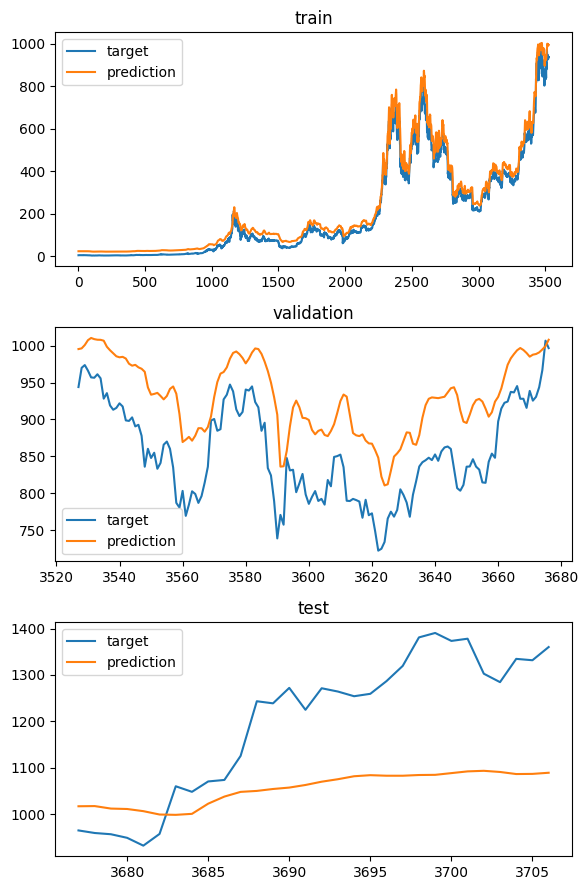

In [12]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
from torch.utils.data import DataLoader
import sys

# 현재 Jupyter Notebook 환경을 고려하여 작업 경로 설정
CURRENT_FILE_PATH = Path.cwd()
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"
if not CHECKPOINT_FILE_PATH.exists():
    os.makedirs(CHECKPOINT_FILE_PATH)

# 외부 모듈 임포트 (p_cryptocurrency_dataset_dataloader.py가 같은 디렉토리에 있다고 가정)
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset
from torch import nn


def get_model(n_input=5, n_output=1, hidden_size=128, num_layers=2):
    """
    LSTM 기반 회귀 모델 정의 함수.
    입력 특성 수(n_input), 출력 차원(n_output), 은닉 상태 크기(hidden_size), LSTM 레이어 수(num_layers)를
    인자로 받아 해당하는 LSTM 모델을 구성한다.
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, num_layers):
            super().__init__()
            # LSTM 레이어: n_input개의 특성을 입력받아 hidden_size 차원의 은닉상태를 가지는 LSTM을 num_layers개 쌓는다.
            # batch_first=True로 batch 차원이 입력 텐서의 첫 번째 차원.
            self.lstm = nn.LSTM(
                input_size=n_input, 
                hidden_size=hidden_size, 
                num_layers=num_layers, 
                batch_first=True
            )
            # LSTM의 마지막 타임스텝 출력을 받아 n_output 차원으로 매핑하는 FC 레이어
            self.fc = nn.Linear(in_features=hidden_size, out_features=n_output)

        def forward(self, x):
            # x: (batch_size, sequence_length, n_input)
            x, _ = self.lstm(x)       # LSTM을 통해 순환 신경망 처리
            x = x[:, -1, :]           # 마지막 타임스텝의 은닉 상태만 사용
            x = self.fc(x)            # FC 레이어를 통해 출력
            return x

    return MyModel(n_input=n_input, n_output=n_output, hidden_size=hidden_size, num_layers=num_layers)


def test(test_model):
    """
    테스트 데이터셋에 대해 모델의 예측 성능을 평가하는 함수.
    Loss(절댓값 오차)를 출력하고, 예측 결과를 확인한다.
    """
    # get_cryptocurrency_data 함수를 통해 데이터 로드
    # 반환값 구조 (X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date)
    data = get_cryptocurrency_data(
        sequence_size=21,
        validation_size=150,
        test_size=30,
        is_regression=True
    )
    X_train, X_validation, X_test, y_train, y_validation, y_test, _, _, _ = data

    # 테스트 데이터셋 생성 및 데이터로더 준비
    test_dataset = CryptoCurrencyDataset(X_test, y_test)
    test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    test_model.eval()     # 모델을 평가 모드로 전환(Dropout, BatchNorm 등 비활성화)
    y_normalizer = 100    # 예측/타깃값을 보기 좋게 스케일링하기 위한 값

    print("[TEST DATA]")
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, targets in test_data_loader:
            # CPU에서 추론
            inputs, targets = inputs.to(torch.device("cpu")), targets.to(torch.device("cpu"))
            outputs = test_model(inputs)

            # 각 샘플별 예측값 vs 실제값 비교 및 손실(절댓값 차이) 출력
            for idx, (output, target) in enumerate(zip(outputs, targets)):
                print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                    idx,
                    output.item() * y_normalizer,
                    target.item() * y_normalizer,
                    abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
                ))


def predict_all(test_model):
    """
    훈련(train), 검증(validation), 테스트(test) 데이터셋 전반에 대해 모델 예측을 수행하고,
    실제값(target)과 예측값(prediction)을 비교하는 그래프를 생성한다.
    """
    y_normalizer = 100  # 값 스케일링을 위한 값

    # 모든 데이터셋 로드 (회귀 모드, y_normalizer를 1.0e7로 설정한 상태)
    X_train, X_validation, X_test, y_train, y_validation, y_test, _, _, _ = get_cryptocurrency_data(
        sequence_size=21,
        validation_size=150,
        test_size=30,
        target_column='Close',
        y_normalizer=1.0e7,
        is_regression=True
    )

    # 훈련, 검증, 테스트 데이터셋 생성
    dataset_list = [
        CryptoCurrencyDataset(X_train, y_train),
        CryptoCurrencyDataset(X_validation, y_validation),
        CryptoCurrencyDataset(X_test, y_test)
    ]
    dataset_labels = ["train", "validation", "test"]

    num = 0  # x축 인덱스용 카운터
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    # 각 데이터셋에 대해 예측 수행 및 그래프 플로팅
    for i in range(3):
        X_points, TARGET_Y, PREDICTION_Y = [], [], []
        for data in dataset_list[i]:
            input, target = data
            # 입력 차원 맞추기: (batch=1, sequence=21, n_features=5)
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X_points.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)
            num += 1

        # 실제값 vs 예측값 그래프
        axs[i].plot(X_points, TARGET_Y, label='target')
        axs[i].plot(X_points, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()


def main():
    """
    메인 실행 함수:
    1. WandB 비활성화 모드로 초기화(테스트용)
    2. 모델 파라미터 로드
    3. 테스트 데이터셋 평가 및 전체 데이터셋에 대한 예측 결과 시각화
    """
    config = {
        "epochs": 100,
        "batch_size": 32,
        "sequence_size": 21,
        "validation_size": 150,
        "test_size": 30,
        "learning_rate": 0.00001,
        "hidden_size": 128,    # 모델 정의 시 사용된 hidden_size
        "lstm_layers": 2,      # 모델 정의 시 사용된 LSTM 레이어 수
        "dropout_rate": 0.3,
        "weight_decay": 0.0001,
        "project_name": "lstm_regression_btc_krw"
    }

    # WandB 초기화 (disabled 모드: 로깅 비활성화)
    wandb.init(
        mode="disabled",
        project=config["project_name"],
        notes="btc_krw regression testing",
        tags=["lstm", "regression", "btc_krw"],
        name=datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        config=config
    )

    # 모델 생성
    test_model = get_model(
        n_input=5,
        n_output=1,
        hidden_size=config["hidden_size"],
        num_layers=config["lstm_layers"]
    )

    # 체크포인트 경로
    latest_file_path = CHECKPOINT_FILE_PATH / f"{config['project_name']}_checkpoint_latest.pt"
    print(f"MODEL FILE: {latest_file_path}")

    # 체크포인트 로드 및 키 이름 조정(필요하다면)
    checkpoint = torch.load(latest_file_path, map_location=torch.device("cpu"))
    model_state = {k.replace("fcn.", "fc."): v for k, v in checkpoint.items()}
    test_model.load_state_dict(model_state, strict=True)

    # 테스트 데이터셋 평가
    test(test_model)

    # 훈련/검증/테스트 데이터 전체 예측 시각화
    predict_all(test_model)


# 메인 함수 실행
main()


### Classification Testing

MODEL FILE: /home/work/HW4/checkpoints/best_model.pt
[TEST RESULTS]
Accuracy: 50.00%
[PREDICTION VISUALIZATION]


/tmp/ipykernel_171/1499796909.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)


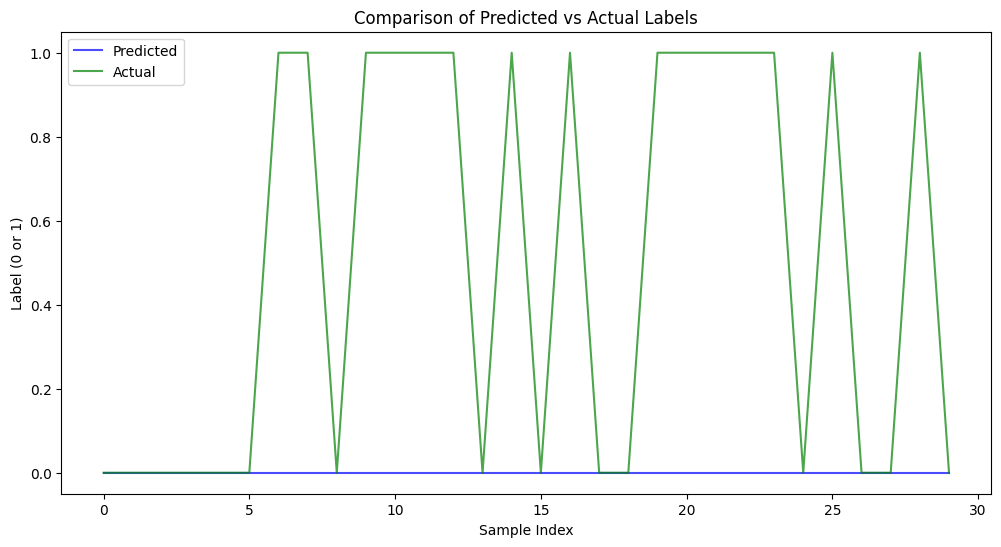

In [16]:
import os
from pathlib import Path
from datetime import datetime
import torch
import wandb
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from torch import nn

# 현재 스크립트가 실행되는 디렉토리 경로 획득
CURRENT_FILE_PATH = Path.cwd()

# 체크포인트 디렉토리 경로 설정
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"

# 체크포인트 디렉토리가 존재하지 않는 경우 생성
if not CHECKPOINT_FILE_PATH.exists():
    CHECKPOINT_FILE_PATH.mkdir(parents=True)

# ----- 데이터셋 클래스 정의 ----- #
class CryptoCurrencyDataset(Dataset):
    """
    암호화폐 데이터셋을 담는 파이토치 Dataset 클래스.
    X: 입력 특성 (시퀀스 형태)
    y: 라벨 (상승/하락 여부)
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        # 데이터셋의 길이 반환
        return len(self.X)

    def __getitem__(self, idx):
        # 인덱스 idx에 해당하는 샘플(X, y) 반환
        # 입력을 float32, 라벨을 long 타입으로 텐서 변환
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)


# ----- 데이터 로드 및 전처리 함수 ----- #
def load_and_prepare_data(sequence_size=21, validation_size=150, test_size=30, target_column="Close", is_regression=False):
    """
    BTC/KRW CSV 파일에서 데이터를 로드하고 전처리하는 함수.
    sequence_size: 각 샘플당 사용할 시퀀스 길이
    validation_size: 검증 데이터로 사용할 샘플 수
    test_size: 테스트 데이터로 사용할 샘플 수
    target_column: 상승/하락 판단 기준이 되는 컬럼 (기본값: "Close")
    is_regression: 회귀 문제인지 여부(여기서는 분류용으로 False)
    """

    # CSV 파일 로드 (실제 경로에 맞게 수정 필요)
    df = pd.read_csv("BTC_KRW.csv")

    # 새로운 특성 추가: 다음날 Open가 (Next_Open), 5일 이동평균(moving_avg)
    df['Next_Open'] = df['Open'].shift(-1)
    df['moving_avg'] = df[target_column].rolling(window=5).mean()

    # 이동평균 계산 등으로 생긴 NaN 제거
    df.dropna(inplace=True)

    # 사용 특성 컬럼
    feature_columns = ["Open", "High", "Low", "Close", "Volume", "Next_Open", "moving_avg"]

    # 정규화: (값 - 평균) / 표준편차
    df[feature_columns] = (df[feature_columns] - df[feature_columns].mean()) / df[feature_columns].std()

    # LSTM 입력용 시퀀스 데이터(X)와 해당 시점의 상승/하락 레이블(y) 생성
    X, y = [], []
    for i in range(len(df) - sequence_size):
        # i부터 i+sequence_size까지를 하나의 시퀀스로
        X.append(df[feature_columns].iloc[i:i + sequence_size].values)
        # 다음 시점의 종가가 이전 시점보다 높으면 1(상승), 아니면 0(하락)
        y.append(1 if df[target_column].iloc[i + sequence_size] > df[target_column].iloc[i + sequence_size - 1] else 0)

    # 파이토치 텐서로 변환
    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

    # 훈련/검증/테스트 데이터 분할
    train_size = len(X) - validation_size - test_size
    X_train, X_val, X_test = X[:train_size], X[train_size:-test_size], X[-test_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:-test_size], y[-test_size:]

    # 테스트용 DataLoader 생성
    test_loader = DataLoader(CryptoCurrencyDataset(X_test, y_test), batch_size=32, shuffle=False)

    return test_loader, X_test, y_test


# ----- 모델 정의 함수 ----- #
def get_model(n_input=7, n_output=2, hidden_size=128, num_layers=2):
    """
    LSTM 기반의 분류 모델을 생성하는 함수.
    n_input: 입력 특성 수
    n_output: 출력 클래스 수(상승/하락 이진분류이므로 2)
    hidden_size: LSTM 은닉층 크기
    num_layers: LSTM 레이어 수
    """
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, num_layers):
            super().__init__()
            # LSTM 레이어 정의
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
            # 완전 연결층 정의
            self.fcn = nn.Linear(in_features=hidden_size, out_features=n_output)

        def forward(self, x):
            # LSTM 순전파
            x, _ = self.lstm(x)
            # 시퀀스의 마지막 타임스텝 출력만 사용
            x = x[:, -1, :]
            # 완전 연결층 통해 최종 출력
            x = self.fcn(x)
            return x

    return MyModel(n_input=n_input, n_output=n_output, hidden_size=hidden_size, num_layers=num_layers)


# ----- 모델 평가 함수 ----- #
def evaluate_model(model, test_loader):
    """
    테스트 데이터로 모델을 평가하는 함수.
    정확도를 출력하고 반환.
    """
    model.eval()
    total_correct = 0
    total_samples = 0

    print("[TEST RESULTS]")
    with torch.no_grad():
        for inputs, targets in test_loader:
            # CPU 디바이스로 설정 (GPU 사용 X)
            inputs, targets = inputs.to(torch.device("cpu")), targets.to(torch.device("cpu"))
            outputs = model(inputs)

            # 예측 클래스
            predicted = torch.argmax(outputs, dim=1)
            # 맞춘 개수 누적
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    accuracy = 100.0 * total_correct / total_samples
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy


# ----- 예측 시각화 함수 ----- #
def predict_all(model, X_test, y_test):
    """
    테스트 셋 전체에 대해 모델의 예측 결과와 실제 라벨을 비교하고,
    이를 시각화하는 함수.
    """
    model.eval()
    predictions = []
    y_test_list = []

    print("[PREDICTION VISUALIZATION]")
    with torch.no_grad():
        for i in range(len(X_test)):
            # 각 샘플을 (1, sequence, features) 형태로
            input = X_test[i].unsqueeze(0)
            # 모델 예측
            prediction = torch.argmax(model(input), dim=1).item()
            predictions.append(prediction)
            y_test_list.append(y_test[i].item())

    # 예측값과 실제값 비교 그래프
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label="Predicted", color="blue", alpha=0.7)
    plt.plot(y_test_list, label="Actual", color="green", alpha=0.7)
    plt.title("Comparison of Predicted vs Actual Labels")
    plt.xlabel("Sample Index")
    plt.ylabel("Label (0 or 1)")
    plt.legend()
    plt.show()


# ----- 메인 함수 (테스트 실행) ----- #
def main():
    # 설정값
    config = {
        "sequence_size": 21,
        "validation_size": 150,
        "test_size": 30,
        "hidden_size": 128,
        "lstm_layers": 2,
        "project_name": "lstm_classification_with_features"
    }

    # WandB 초기화 (테스트 모드이므로 disabled)
    wandb.init(
        mode="disabled",
        project=config["project_name"],
        notes="btc_krw classification testing",
        tags=["lstm", "classification", "btc_krw"],
        name=datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        config=config
    )

    # 테스트 데이터 로드
    test_loader, X_test, y_test = load_and_prepare_data(
        sequence_size=config["sequence_size"],
        validation_size=config["validation_size"],
        test_size=config["test_size"]
    )

    # 모델 생성
    model = get_model(
        n_input=7,      # 위에서 feature_columns가 7개이므로 7
        n_output=2,     # 이진 분류
        hidden_size=config["hidden_size"],
        num_layers=config["lstm_layers"]
    )

    # 체크포인트 파일 경로
    checkpoint_path = CHECKPOINT_FILE_PATH / "best_model.pt"
    print(f"MODEL FILE: {checkpoint_path}")

    # 체크포인트 로드 (CPU)
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cpu")))
    model.to(torch.device("cpu"))

    # 모델 평가
    evaluate_model(model, test_loader)

    # 예측 결과 시각화
    predict_all(model, X_test, y_test)

    # WandB 종료
    wandb.finish()


# 메인 함수 실행
if __name__ == "__main__":
    main()


### 비교 해석

In [ ]:
Regression 코드:

MSELoss를 사용하고, 모델 출력 값과 실제 값의 차이를 직접 계산합니다.
테스트 시 output.item()으로 예측 값을 그대로 비교.
시각화 시, 예측 값과 실제 값을 연속 그래프로 플롯.
Classification 코드:

CrossEntropyLoss를 사용하며, 예측 확률 분포에서 torch.argmax로 클래스 라벨을 선택합니다.
테스트 시 torch.argmax(output)로 예측 클래스 라벨을 계산.
시각화 시, 정확도와 클래스 별 분포를 시각화하거나 혼동행렬을 생성.
따라서, 두 문제의 차이는 문제 정의, 출력 형태, 손실 함수, 평가 지표, 그리고 시각화 전략에서 비롯됩니다. 이를 염두에 두고 코드를 설계하면 두 문제를 적절히 처리할 수 있습니다.

### 고찰

In [ ]:
LSTM 모델의 한계 및 개선 방향

단순 LSTM을 사용한 시계열 예측은 일정 수준의 성능을 제공하지만, 최근에는 Transformer 기반 모델, Temporal Fusion Transformer, N-BEATS 등 더 발전된 시계열 모델들이 등장하였다.
코드 구조를 모듈화하고 확장성 있게 설계했기 때문에, 향후 LSTM 이외의 다른 아키텍처를 적용하는 실험을 쉽게 시도할 수 있다.
하이퍼파라미터 중요성

hidden_size, lstm_layers, dropout_rate, learning_rate, weight_decay 등의 하이퍼파라미터 변화를 통해 모델 성능이 크게 좌우됨을 확인했다.
자동화된 실험 관리(WandB 연동)를 통해 하이퍼파라미터 스윕 및 최적화 전략을 체계적으로 수행할 수 있다.
데이터 품질 및 전처리

시계열 모델의 성능은 데이터 품질에 크게 의존한다.
추후 이상값 제거, 더 긴 시계열 특징 반영, 외부 변수(거래량, 글로벌 시장 지표 등) 추가 등을 통해 모델 입력을 풍부하게 하여 성능 향상을 시도할 수 있다.
데이터 정규화(y_normalizer)를 적절히 선택하는 것의 중요성을 인식하였으며, 이를 통해 예측값과 실제값 차이를 직관적으로 비교하기 더 쉬워졌다.
모듈화와 재사용성

모델 정의, 데이터로더, 학습 루프, 테스트 및 시각화 코드를 모듈화함으로써 재사용성과 유지보수성을 높였다.
이는 추후 다른 금융 자산이나 다른 시계열 데이터셋으로 확장할 때 최소한의 코드 수정으로 동일한 파이프라인을 사용할 수 있게 한다.
해석 가능성

LSTM 모델 자체의 해석 가능성은 제한적이지만, 향후 Integrated Gradients나 Grad-CAM과 같은 기법을 적용해 입력 시계열 중 어느 부분이 예측에 기여하는지 해석해볼 수 있다.
시계열 예측 결과를 시각화함으로써 모델이 어느 구간에서 예측 성능이 저하되는지 확인할 수 있으며, 이를 바탕으로 데이터 특성과 모델 개선 방향을 고민할 수 있다.
이와 같이, 코드를 통해 시계열 데이터 예측 모델(LSTM 기반) 구현, 학습 및 평가를 진행하면서 다양한 기술적 사항과 개선 방향, 그리고 데이터 전처리 및 하이퍼파라미터 중요성에 대한 통찰을 얻게 되었다. 이를 토대로 향후 더 복잡하고 다양한 시나리오에 대한 모델링에 도전할 수 있을 것이다.

### 숙제후기

In [ ]:
이 과제를 통해 머신러닝 프로젝트의 모든 단계를 실습하며, 
모델 개발뿐만 아니라 데이터 전처리, 하이퍼파라미터 튜닝, 
성능 평가 및 실험 관리의 중요성을 배울 수 있었습니다. 
Regression과 Classification의 차이를 명확히 이해하고, 
이를 적절히 구현하는 방법을 익힌 것은 앞으로의 프로젝트에서 큰 자산이 될 것 같습니다.